In [1]:
import pandas as pd

df = pd.read_csv('MSFT.csv')

In [2]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9690,2024-08-26,413.489990
9691,2024-08-27,413.839996
9692,2024-08-28,410.600006
9693,2024-08-29,413.119995


In [3]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9690    2024-08-26
9691    2024-08-27
9692    2024-08-28
9693    2024-08-29
9694    2024-08-30
Name: Date, Length: 9695, dtype: object

In [4]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [5]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9690   2024-08-26
9691   2024-08-27
9692   2024-08-28
9693   2024-08-29
9694   2024-08-30
Name: Date, Length: 9695, dtype: datetime64[ns]

In [6]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-08-26,413.489990
2024-08-27,413.839996
2024-08-28,410.600006


In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [29]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [30]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

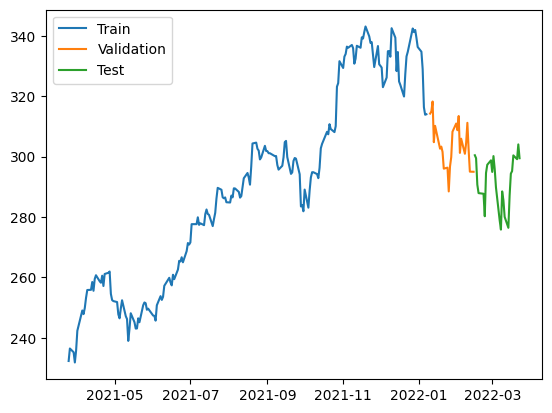

In [31]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [14]:
!pip install --upgrade --force-reinstall tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/b4/71/1ac7960071a524fa25d7e9dd5040da26d3e15802d869c588d7e4cd8036f9/tensorflow-2.17.0-cp39-cp39-win_amd64.whl.metadata
  Using cached tensorflow-2.17.0-cp39-cp39-win_amd64.whl.metadata (3.2 kB)
  Obtaining dependency information for tensorflow-intel==2.17.0 from https://files.pythonhosted.org/packages/91/de/766523b1e75d7f32f2db768887c1ed392a9b5c71eab304483284f7ae9e27/tensorflow_intel-2.17.0-cp39-cp39-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.17.0-cp39-cp39-win_amd64.whl.metadata (5.0 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb7

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ROSA\\miniconda3\\envs\\ryzenai\\Lib\\site-packages\\~umpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll'
Consider using the `--user` option or check the permissions.



In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 83359.1484 - mean_absolute_error: 286.9823 - val_loss: 91816.4531 - val_mean_absolute_error: 302.9249
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82589.6016 - mean_absolute_error: 285.5841 - val_loss: 91348.0781 - val_mean_absolute_error: 302.1508
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 82162.1719 - mean_absolute_error: 284.9968 - val_loss: 90678.5625 - val_mean_absolute_error: 301.0409
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 82547.7891 - mean_absolute_error: 285.5036 - val_loss: 89815.2422 - val_mean_absolute_error: 299.6035
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 82054.5938 - mean_absolute_error: 284.6785 - val_loss: 88782.0312 - val_mean_absolute_error: 297.8743
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 80078.9531 - mean_absolute_error: 281.2132 - val_loss: 87591.4688 - val_mean_absolute_error: 295.8690
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


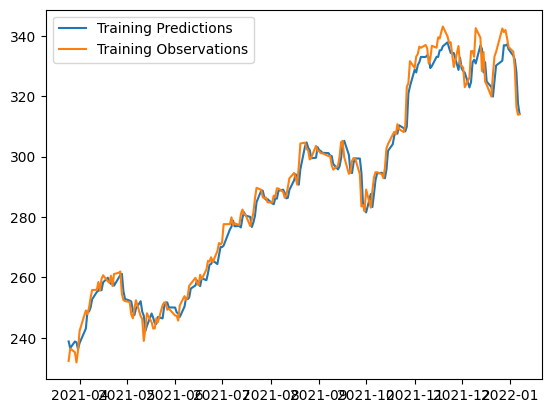

In [33]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


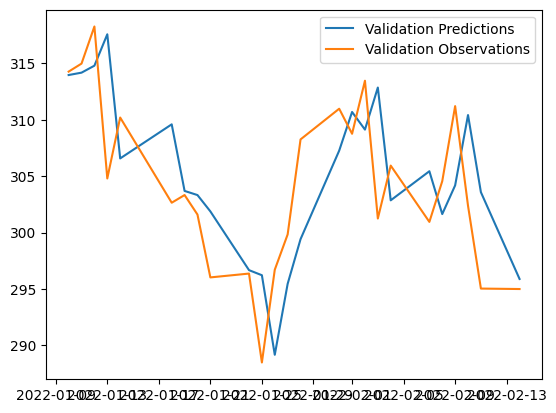

In [34]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


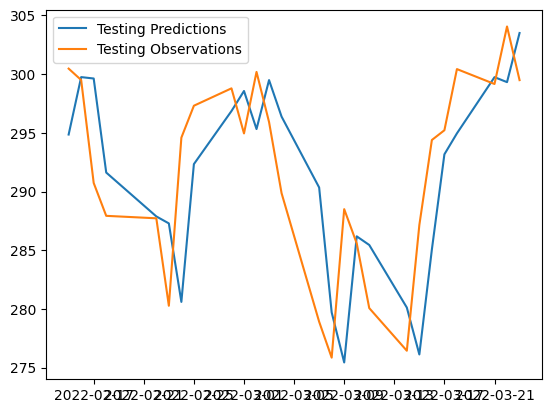

In [35]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

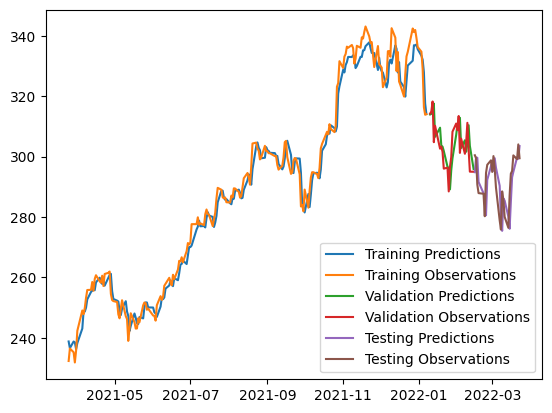

In [36]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])